# Set up the working directory and enviroment

In [18]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/combined1_hNGN2/scanpy")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Assign folders for storing input data, object, and output
1. 'data' folder: storing .mtx or h5 from 10xGenomic sequencing 
2. 'interim' folder: storing h5ad object after processing and its output files, e.g., top_markers.csv
3. 'figures' folder: automatically generated

In [0]:
# ! mkdir ./data
# ! mkdir ./interim
results_file = 'scanpy_out/combined1_neuron.h5ad'

## Installed the required packages

In [0]:
# required for umap clustering
! pip3 install leidenalg 
! pip3 install scanpy
# ! pip install python-igraph
# ! pip install louvain
import h5py
import numpy as np
import pandas as pd
import scanpy as sc

## Set up the displaying and print parameters

In [22]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.0


# Data preprocessing
1. Use gene symbols for the variable names (variables-axis index)
3. Write a cache file for faster subsequent reading
4. De-duplicates

## Read 10xGenomics sc-RNA sequencing data

In [23]:
adata = sc.read_10x_h5("data_for_scanpy/scRNA_Seq_experiment_1_Combined1_hNGN2_outs_filtered_feature_bc_matrix.h5")                               

reading data_for_scanpy/scRNA_Seq_experiment_1_Combined1_hNGN2_outs_filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [0]:
adata.var_names_make_unique()

## Basic filtering
1. cell based filtering: remove cells with less than 200 genes
2. gene based filtering: remove genes expressing in less than 3 cells

In [25]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 14 cells that have less than 200 genes expressed
filtered out 12625 genes that are detected in less than 3 cells


## Calculate the percentage of mitochondrial genes

In [0]:
mito_genes = adata.var_names.str.startswith('MT-')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

## Check sequencing quality
1. choose the threthold of gene numbers to remove, e.g., n_genes = 7000
2. choose the threthold of mitochondial genes to remove, e.g., percent_mito = 0.25

... storing 'feature_types' as categorical
... storing 'genome' as categorical


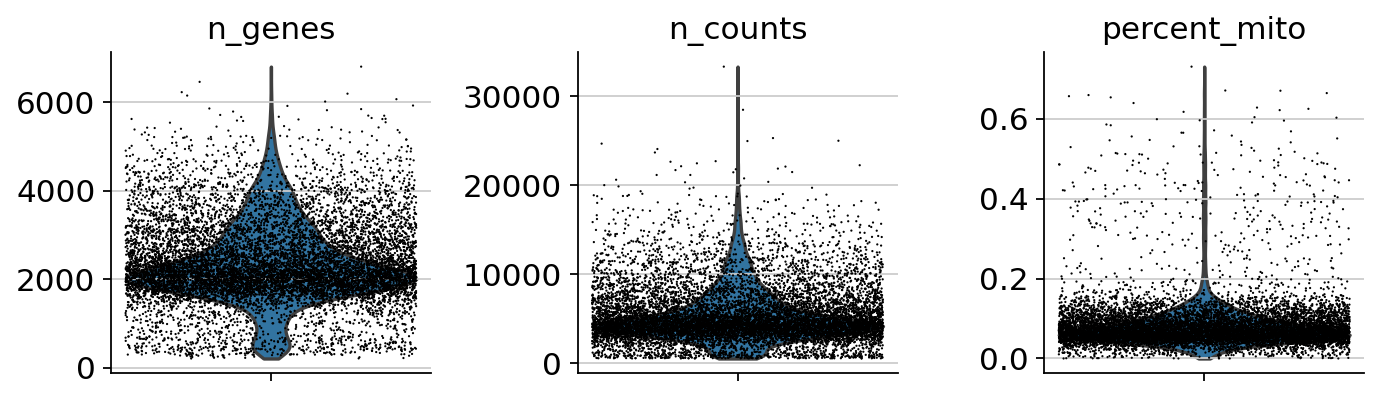

In [27]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

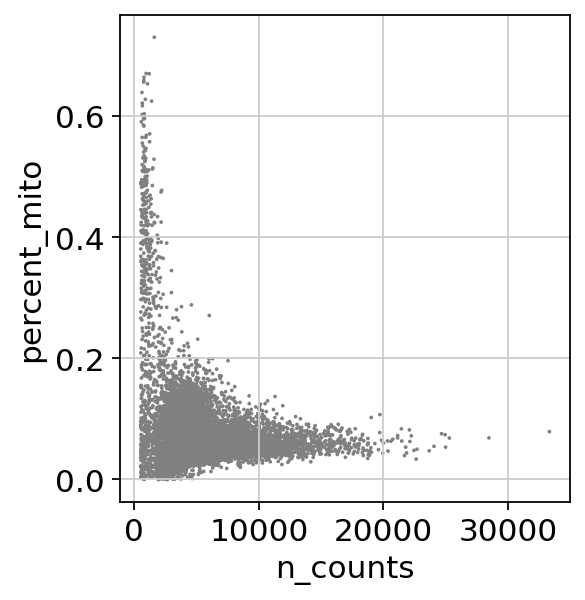

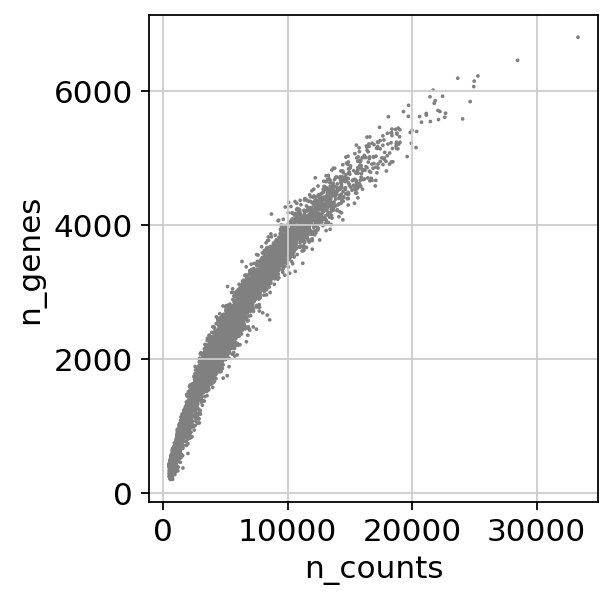

In [28]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [29]:
adata = adata[adata.obs.n_genes < 7500, :]
adata = adata[adata.obs.percent_mito < 0.25, :]
adata

View of AnnData object with n_obs × n_vars = 10342 × 20913 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Scale and logarithmize the data
option: store the unnormalized data in .raw

In [30]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw=adata

normalizing counts per cell
    finished (0:00:20)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [31]:
adata

AnnData object with n_obs × n_vars = 10342 × 20913 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'log1p'

In [0]:
adata.write_h5ad("combined1_hNGN2_18April2020.h5d")

## Choosing highly-variable genes for further analysis
Subset is optional. If subset using adata.var.highly_variable, the adata will only contain these genes.

In [34]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


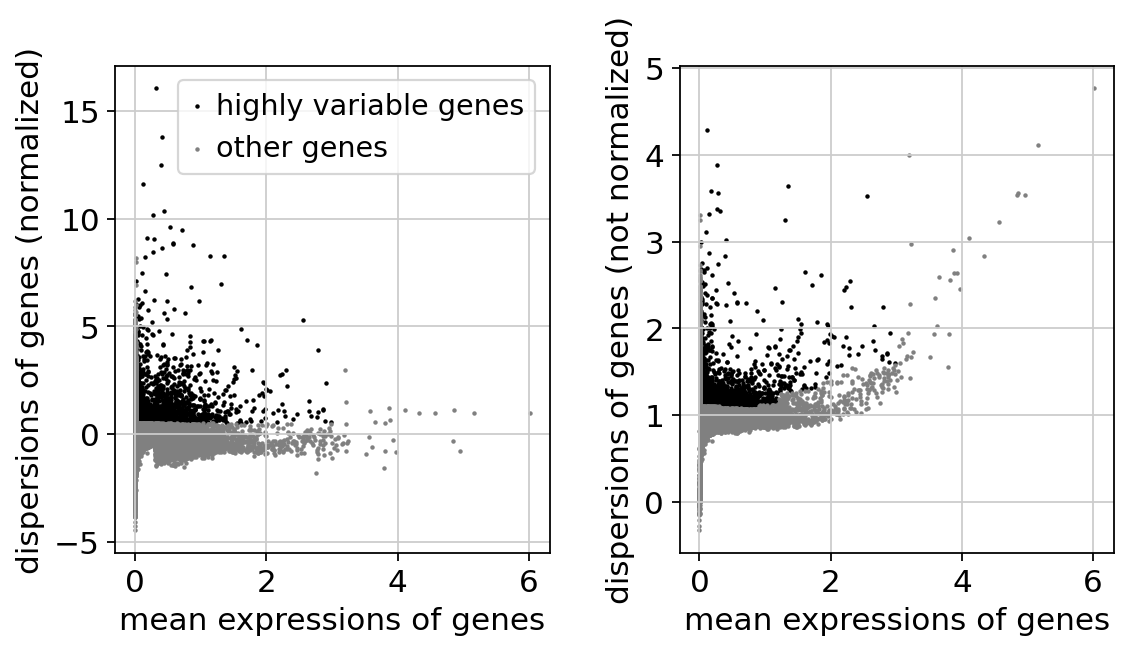

In [35]:
sc.pl.highly_variable_genes(adata)

In [0]:
adata = adata[:, adata.var.highly_variable]

In [37]:
adata

View of AnnData object with n_obs × n_vars = 10342 × 2814 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Further scale
1. Regression out n_counts and percent_mito effect and scale again on adata which only contains highly-variable genes now.
2. Clip values exceeding standard deviation 10 (max_value=10)

In [38]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:39)


# Principal component analysis

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:06)


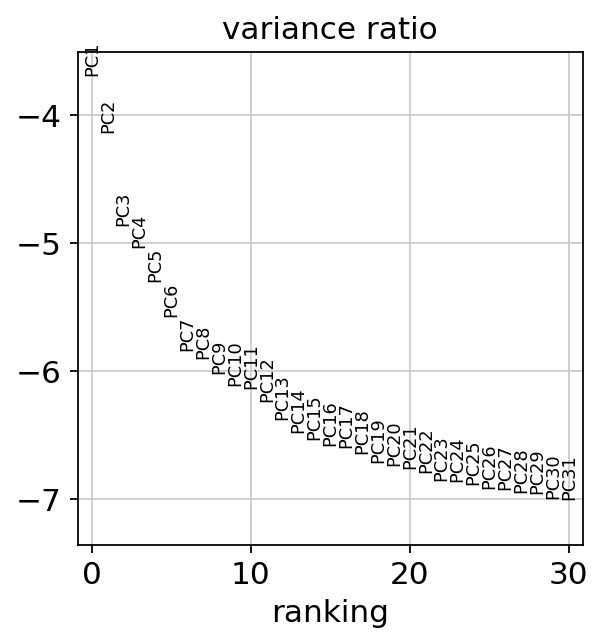

In [39]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)


### Computing, embedding, and clustering the neighborhood graph

1. Computing the neighborhood graph of cells using the PCA representation of the data matrix.
2. Embedding the graph in 2 dimensions using UMAP.
3. Clustering the neighborhood graph using Leiden graph-clustering method 

In [42]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


In [43]:
adata

AnnData object with n_obs × n_vars = 10342 × 2814 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Visualize the clusters

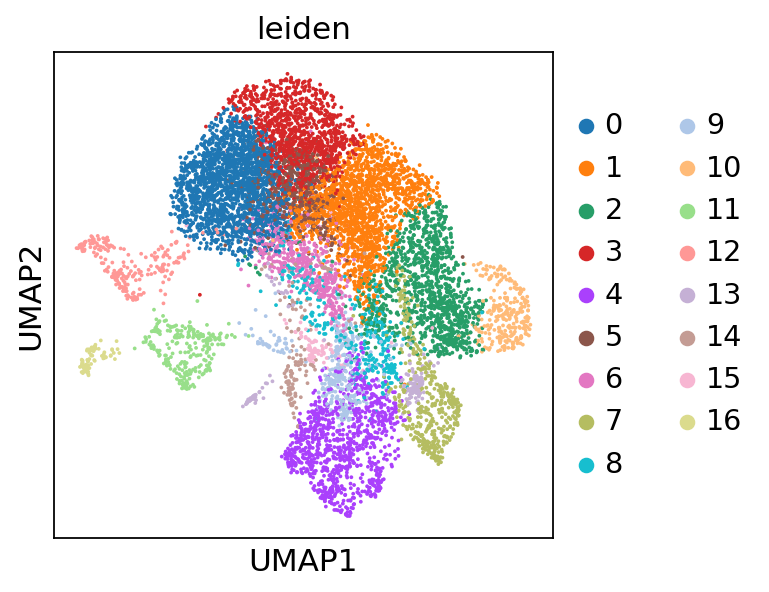

In [48]:
sc.pl.umap(adata, color=['leiden'], save='combined1_hNGN2.pdf')

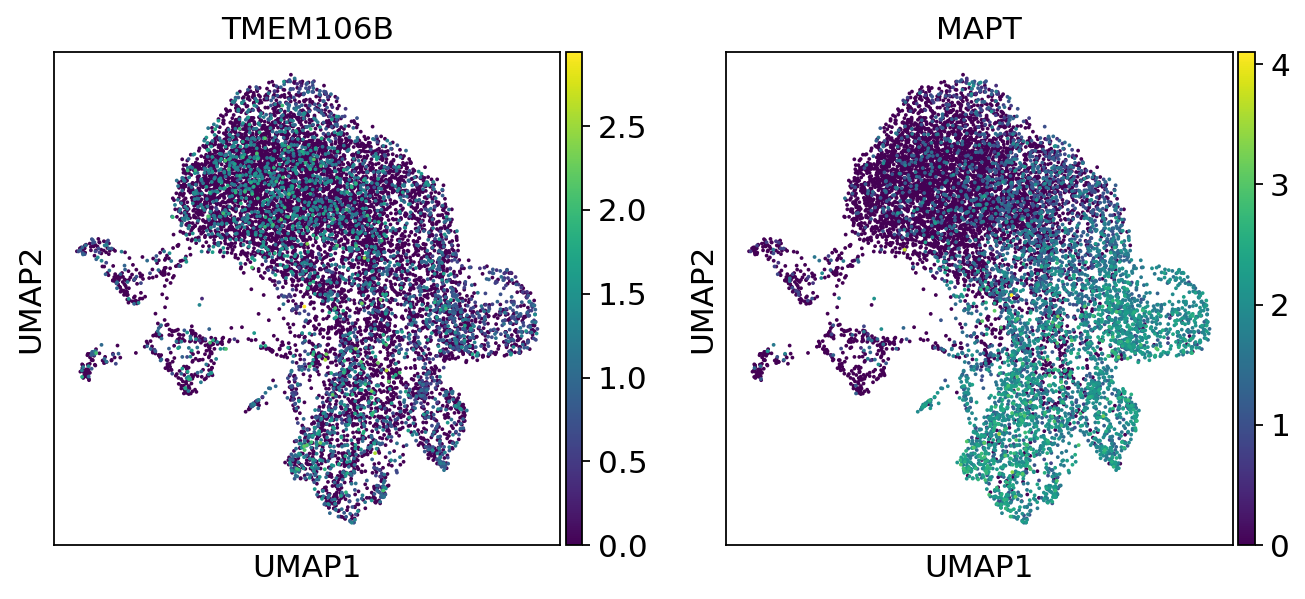

In [47]:
sc.pl.umap(adata, color=['TMEM106B','MAPT'])

## Save the processed adata object saved as .h5ad
The object can be load using adata = sc.read(results_file)

In [0]:
adata.write(results_file)

# Finding marker genes
one vs rest comparison using Mann-Whitney-U-test (recommend)

In [0]:
# reduce the verbosity from 3 to 2 in the setting of logging output
sc.settings.verbosity = 2 

ranking genes
    finished (0:00:19)


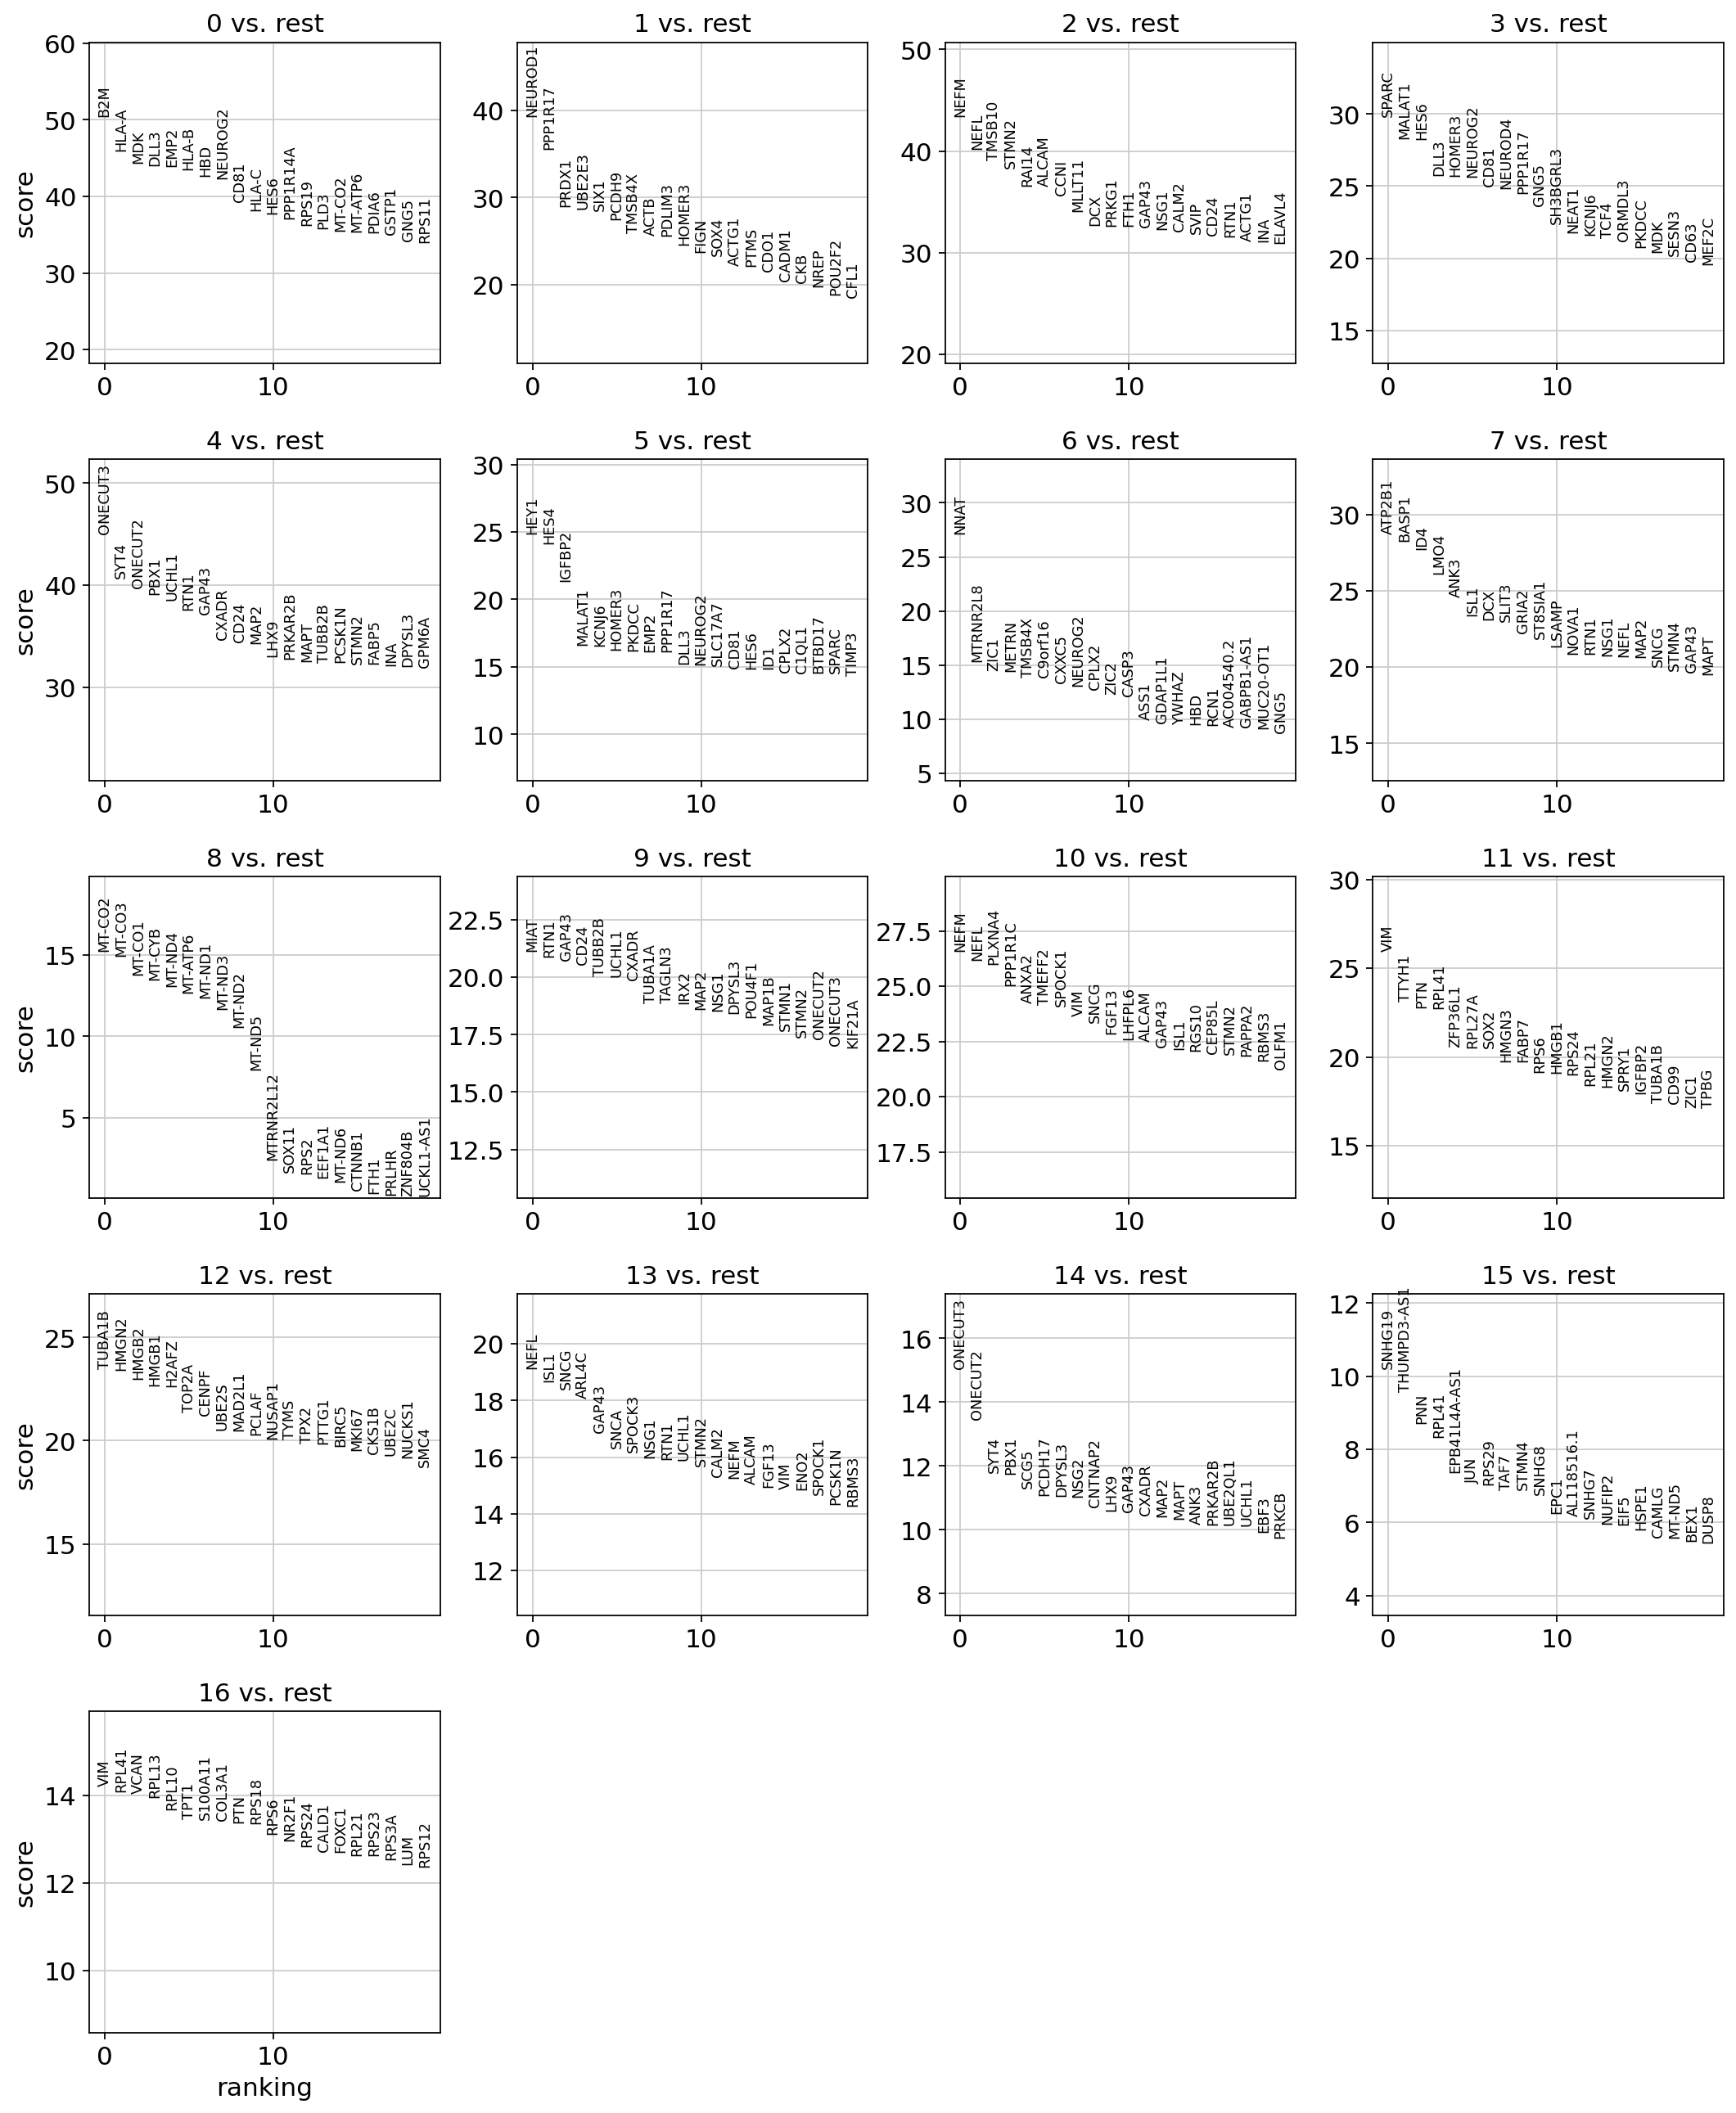

In [52]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## Visualize the differential expression of marker genes across clusters
1. Differential expression a set of marker genes of a specific cluster vs the rest.
2. Differential expression of a single gene across all clusters

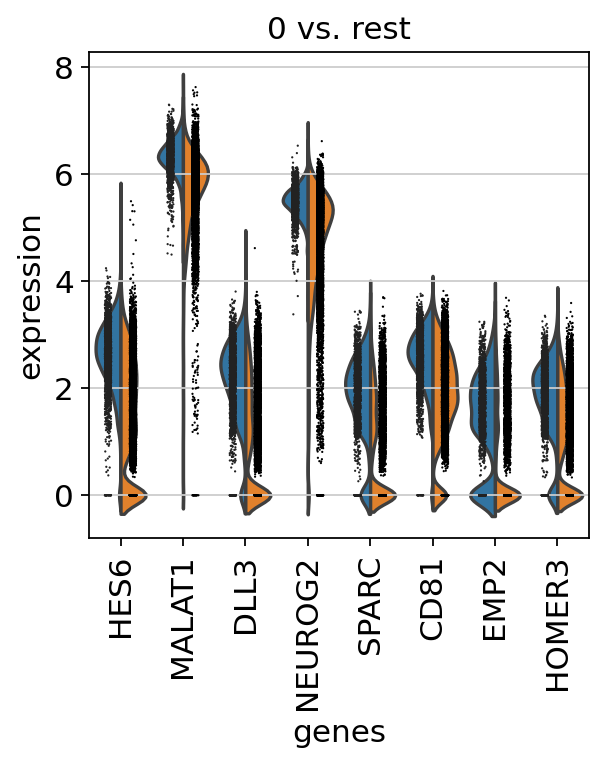

In [0]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

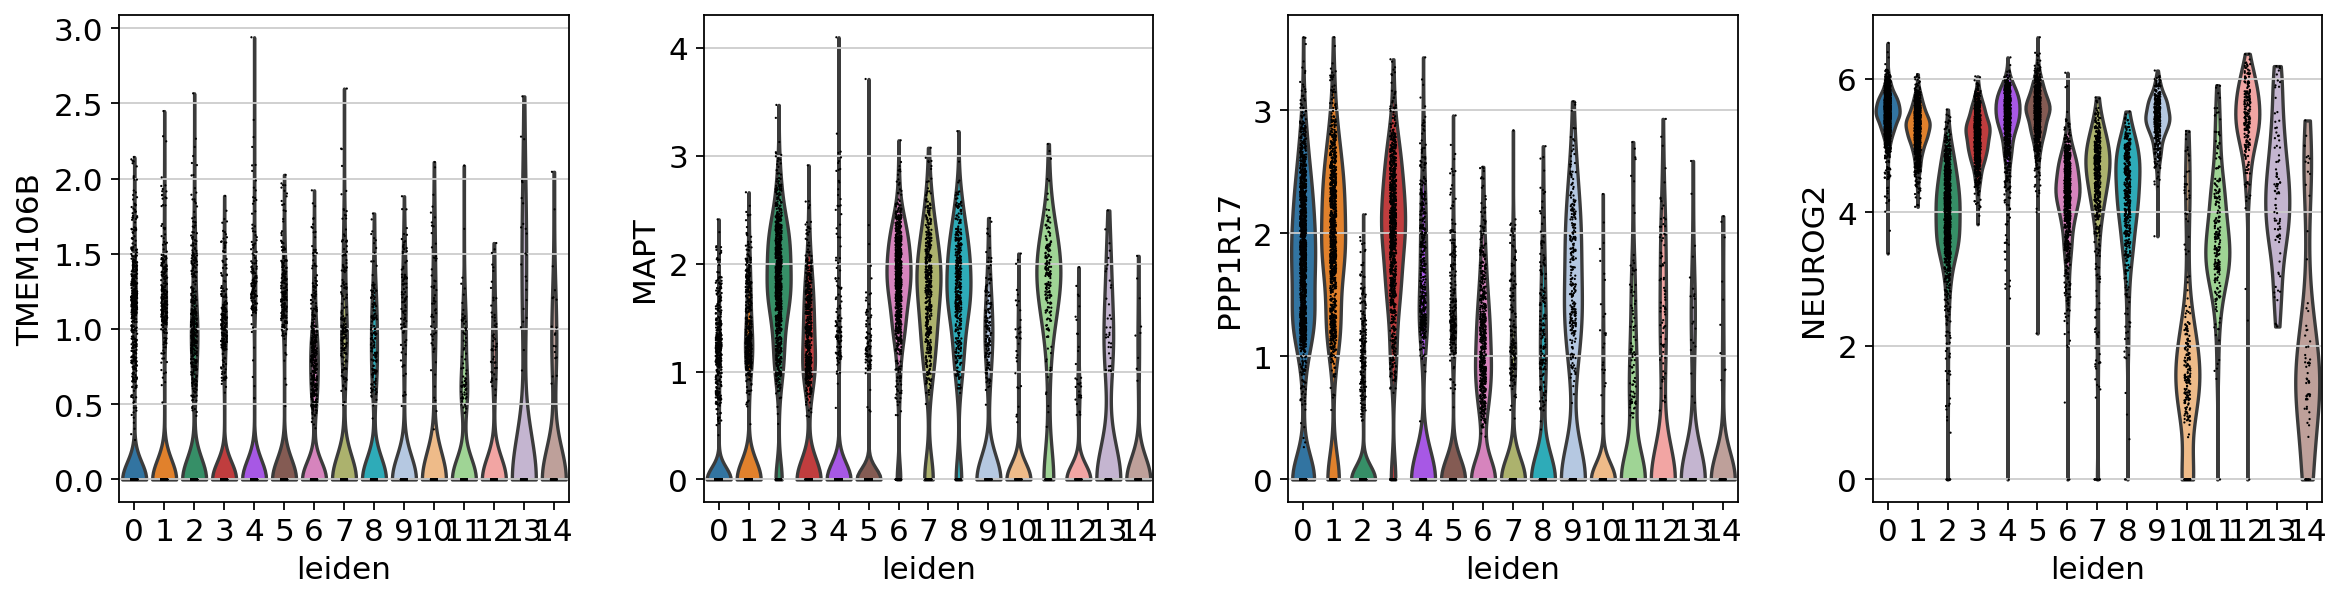

In [0]:
sc.pl.violin(adata, ['TMEM106B', 'MAPT', "PPP1R17", "NEUROG2"], groupby='leiden')

## Annotate cell types for all the clusters 
Based on domain knowledge and information of marker genes

Wait for disscussion for this case


In [0]:
# assign cell type names to the clusters
# new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']

# adata.rename_categories('leiden', new_cluster_names)

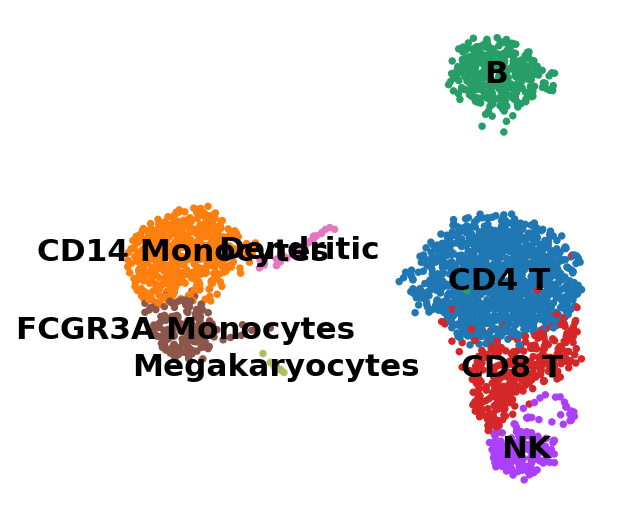

In [0]:
# it automatically generates a folder of 'figures' and save the figure inside 
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

# Export a list of marker genes

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)

top_marker_genes.to_csv('scanpy_out/top_markers_combined1_hNGN2.csv')

In [56]:
top_marker_genes.head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p
0,B2M,0.0,NEUROD1,0.000000e+00,NEFM,0.000000e+00,SPARC,1.155062e-195,ONECUT3,0.0,HEY1,1.102096e-136,NNAT,2.079472e-162,ATP2B1,9.873014e-182,MT-CO2,2.049262e-52,MIAT,3.176848e-99,NEFM,7.705019e-156,VIM,9.105686e-149,TUBA1B,3.233443e-122,NEFL,1.223102e-81,ONECUT3,2.895115e-51,SNHG19,1.659336e-24,VIM,7.078307e-46
1,HLA-A,0.0,PPP1R17,1.996984e-277,NEFL,0.000000e+00,MALAT1,2.203855e-176,SYT4,0.0,HES4,4.744222e-129,MTRNR2L8,3.429132e-53,BASP1,1.789532e-175,MT-CO3,3.249441e-50,RTN1,6.971203e-97,NEFL,3.425596e-151,TTYH1,2.330934e-118,HMGN2,1.971871e-121,ISL1,9.707455e-78,ONECUT2,3.000772e-41,THUMPD3-AS1,8.480152e-22,RPL41,4.706204e-45
2,MDK,0.0,PRDX1,6.335377e-185,TMSB10,0.000000e+00,HES6,1.168425e-175,ONECUT2,0.0,IGFBP2,4.085797e-101,ZIC1,1.158058e-47,ID4,3.282880e-169,MT-CO1,4.367266e-43,GAP43,2.095056e-95,PLXNA4,5.026066e-149,PTN,4.101293e-115,HMGB2,6.629459e-117,SNCG,1.067199e-75,SYT4,4.060879e-32,PNN,2.903318e-18,VCAN,9.269207e-45
3,DLL3,0.0,UBE2E3,6.915241e-181,STMN2,0.000000e+00,DLL3,4.919633e-146,PBX1,0.0,MALAT1,6.580836e-62,METRN,2.376905e-47,LMO4,5.014336e-150,MT-CYB,1.986600e-41,CD24,6.865104e-94,PPP1R1C,3.171733e-138,RPL41,2.604090e-114,HMGB1,1.403965e-113,ARL4C,4.516790e-73,PBX1,6.597661e-32,RPL41,7.427137e-17,RPL13,2.984641e-44
4,EMP2,0.0,SIX1,7.955425e-179,RAI14,5.897877e-293,HOMER3,2.759414e-145,UCHL1,0.0,KCNJ6,9.556269e-62,TMSB4X,4.248613e-44,ANK3,1.572837e-133,MT-ND4,3.923301e-39,TUBB2B,1.099417e-89,ANXA2,6.057025e-130,ZFP36L1,6.637362e-94,H2AFZ,2.529223e-113,GAP43,5.722046e-64,SCG5,1.248950e-29,EPB41L4A-AS1,1.632184e-13,RPL10,1.612779e-42


In [0]:
# get a list of top20 marker genes of cluster 1
marker_genes_cluster1 = top_marker_genes["1_n"][:20].values

# Visulize gene differential expression 
maker genes or other gene of interest


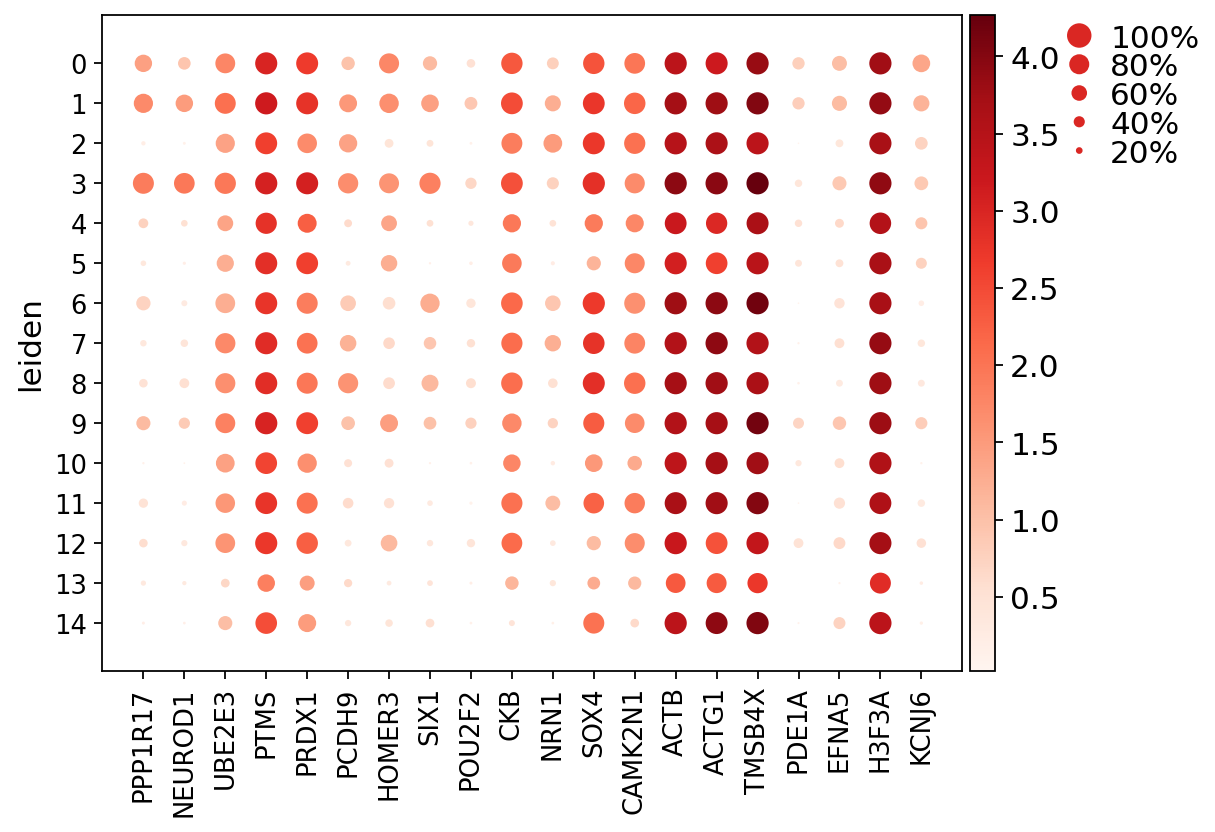

In [0]:
ax = sc.pl.dotplot(adata, marker_genes_cluster1, groupby='leiden')

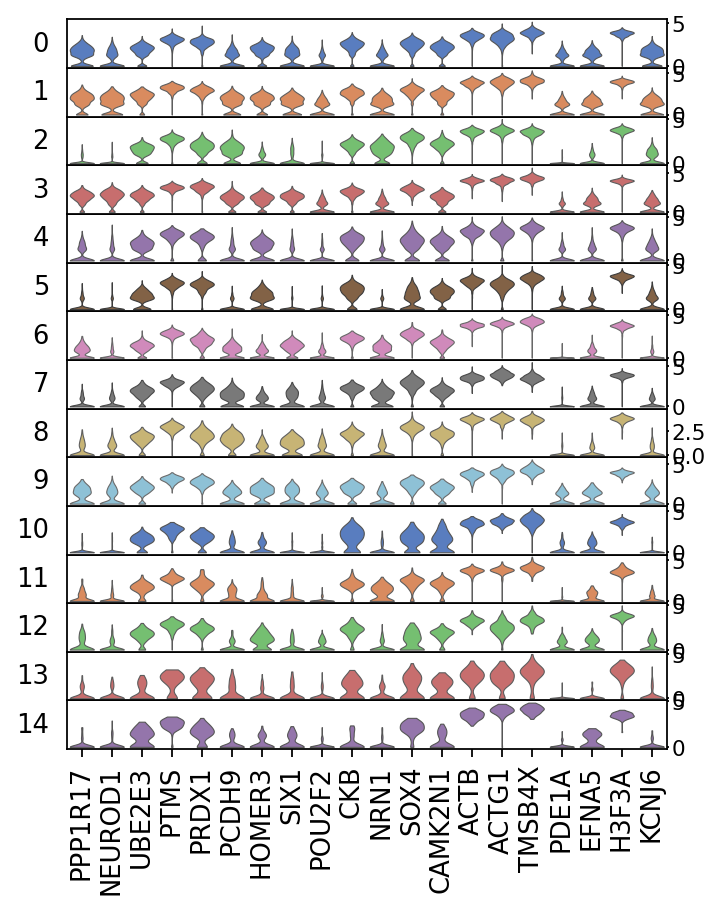

In [0]:
ax = sc.pl.stacked_violin(adata, marker_genes_cluster1, groupby='leiden', rotation=90)

# Save the work
option: export a set of csv using 
adata.write_csvs(results_file[:-5])

In [0]:
adata.write(results_file)

In [77]:
%ls scanpy_out/

combined1_hNGN2.h5ad  top_markers_combined1_hNGN2.csv


In [0]:
!mv scanpy_out/top_markers_combined1_neurons_hNGN_20April2020.csv scanpy_out/top_markers_combined1_hNGN2.csv